In [45]:
import numpy as np
import scipy
from random import choice

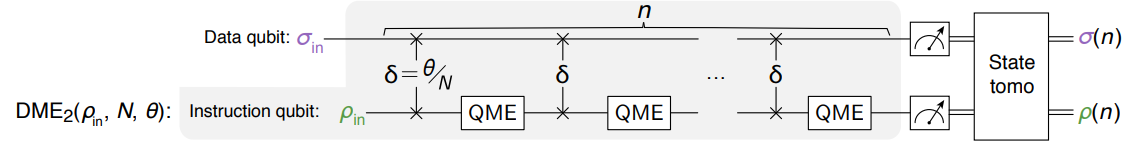

Define partial trace and Hermitian conjugate function

Pauli matrices etc

In [46]:
X = np.array([[0,1],
              [1,0]])

Y = np.array([[0,-1j],
              [1j,0]])

Z = np.array([[1,0],
              [0,-1]])

I = np.array([[1,0],
              [0,1]])

swap = np.array([[1, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1]])

XX = np.kron(X,X)
YY = np.kron(Y,Y)
ZZ = np.kron(Z,Z)


In [47]:
def ptrace(matrix,index=1,n1=2,n2=2):
    # Partial trace function for density matrices.
    current_tensor=matrix.reshape([n1, n2, n1, n2])
    if index == 1:
        return np.trace(current_tensor, axis1=1, axis2=3)
    elif index == 2:
        return np.trace(current_tensor, axis1=0, axis2=2)
    else:
        print('Error')

def dagger(u):
    return np.asarray(np.matrix(u).H)

from scipy.linalg import sqrtm
def fidelity(rho1, rho2):
    # Compute the square root of the first density matrix
    sqrt_rho1 = sqrtm(rho1)
    # Compute the matrix product of sqrt(rho1) * rho2 * sqrt(rho1)
    product = sqrt_rho1 @ rho2 @ sqrt_rho1    
    # Compute the square root of the product matrix
    sqrt_product = sqrtm(product)    
    return np.real(np.trace(sqrt_product)) ** 2

def measure(psi, projectors=None):
    if projectors is None:
        # Default to computational basis projectors for a qubit
        projectors = [np.array([[1, 0], [0, 0]]),  # |0⟩⟨0|
                      np.array([[0, 0], [0, 1]])]  # |1⟩⟨1|
    
    probs = [np.vdot(psi, P @ psi).real for P in projectors]
    outcome = choice(len(projectors), p=probs)
    return outcome



Define the qubit initial density matrices

In [48]:
ket_plus = np.array([[1],[0]])
rho_plus = np.outer(ket_plus,ket_plus)

#ket_0 = np.array([[1],[0]])

ket_0 = np.array([[1/np.sqrt(2)],[1j/np.sqrt(2)]])
rho_0 = np.outer(ket_0,ket_0.conj().T)

t = np.pi

Define the unitaries

In [49]:
fidelity_with_state = rho_0

In [50]:
def U_rho(t,rho):
    return scipy.linalg.expm(-1j*t*rho)

state = rho_0
fidelities_expect = []
for i in range(num_muq):
    _U = U_rho(t*i,rho_plus)
    state = _U @ rho_0 @ dagger(_U)
    fidelities_expect.append(fidelity(state,fidelity_with_state))


In [51]:
# Native SWAP

def U(t):
    return scipy.linalg.expm(-1j*t*swap)
np.round(U(t) @ np.kron(rho_0,rho_plus) @ dagger (U(t)),3)

array([[ 0.5+0.j , -0. -0.j ,  0. -0.5j,  0. +0.j ],
       [-0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ],
       [ 0. +0.5j,  0. -0.j ,  0.5+0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ]])

In [52]:
II = np.kron(I,I)
IX = np.kron(I,X)
def qme(state,u):
    gate = choice([II,IX])
    return gate @ u @ state @ dagger(u) @ dagger(gate)


In [53]:
num_tomo = 50
num_muq = 100
from matplotlib import cm
color = cm.rainbow(np.linspace(1, 0, num_muq))
from qutip import Bloch, Qobj
import qutip


In [54]:
initial_state = np.kron(rho_0,rho_plus)
average_states =  []
_t = t/num_muq
u = U(_t)

for muq in range(num_muq):
    states = []

    # Repeat the n randomized muq steps for tomography
    for j in range(num_tomo):

        # Do n muq, where n go from 0 to N
        state = initial_state
        for i in range(muq):
            state = qme(state,u)
        
        states.append(state)
    
    average_states.append(np.mean(states,axis=0))

qutip_states = [Qobj(ptrace(state)) for state in average_states]
qutip_mem_states = [Qobj(ptrace(state,index=2)) for state in average_states]

In [55]:
dme_state = np.kron(rho_0,rho_plus)
dme_W_states = []
# Normal DME
for muq in range(num_muq):
    dme_state = u @ dme_state @ dagger(u)
    rho_W = ptrace(dme_state)
    dme_state = np.kron(rho_W,rho_plus)
    dme_W_states.append(rho_W)

qutip_dme_states = [Qobj(state) for state in dme_W_states]

dme work qubit:


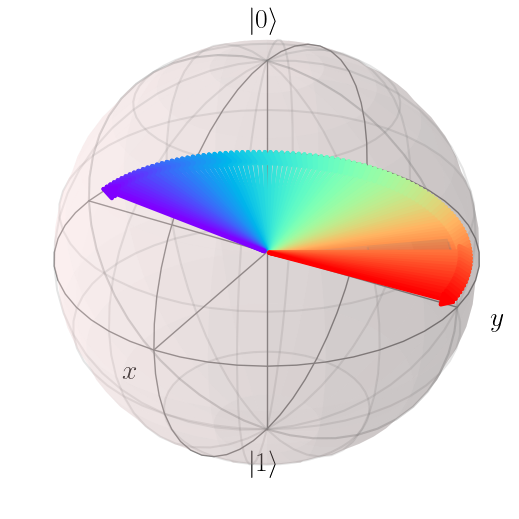

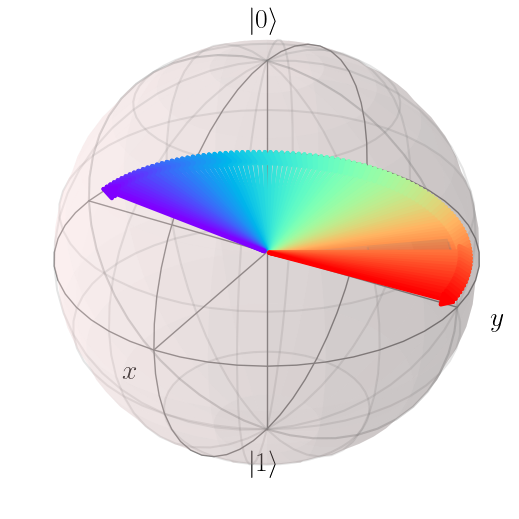

In [56]:
b = Bloch()
b.fig
b.vector_color = color.tolist()
print('dme work qubit:')
for state in qutip_dme_states:
    b.add_states(state)
b.show()

Memory qubit:


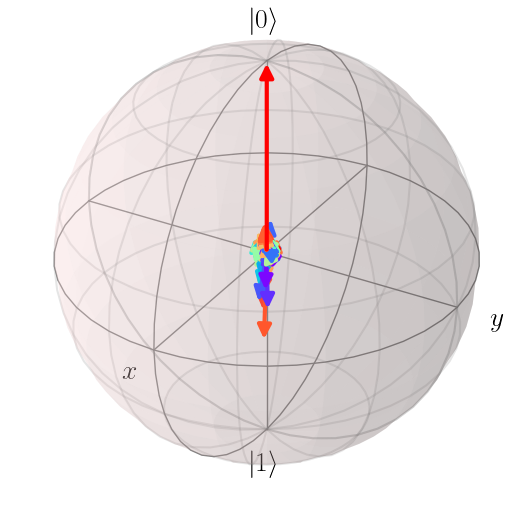

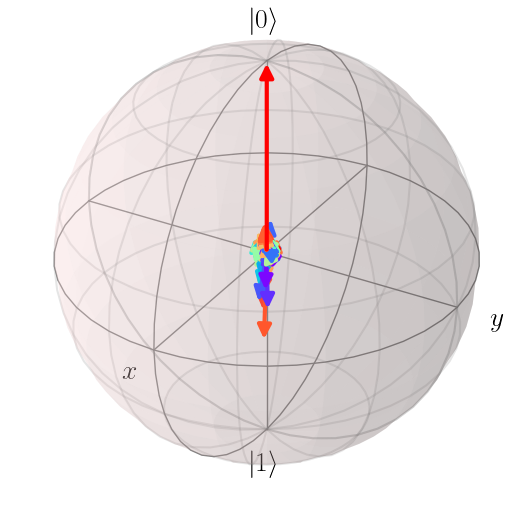

In [57]:
b = Bloch()
b.fig
b.vector_color = color.tolist()
print('Memory qubit:')
for state in qutip_mem_states:
    b.add_states(state)
b.show()

Work qubit:


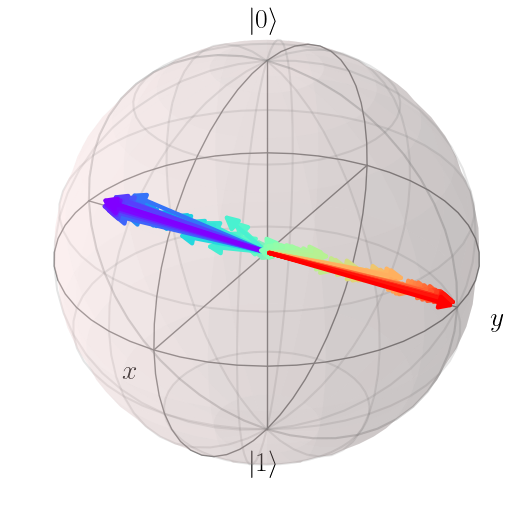

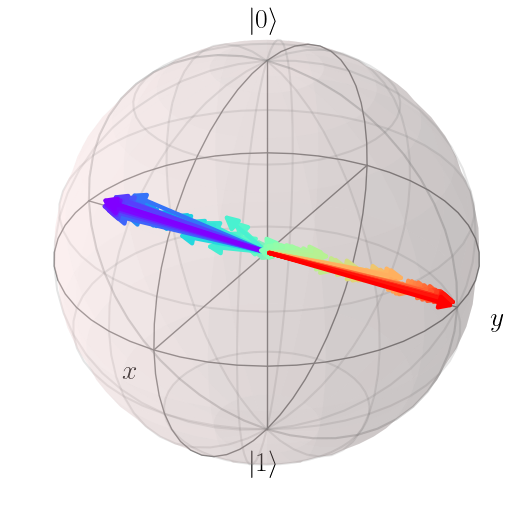

In [58]:
b = Bloch()
b.fig
b.vector_color = color.tolist()
print('Work qubit:')
for state in qutip_states:
    b.add_states(state)
b.show()

In [59]:
_U = U_rho(t/2,rho_plus)
expected_state = _U @ rho_0 @ dagger(_U)
print(np.round(expected_state,3))

[[ 0.5+0.j -0.5-0.j]
 [-0.5+0.j  0.5+0.j]]


Expected:


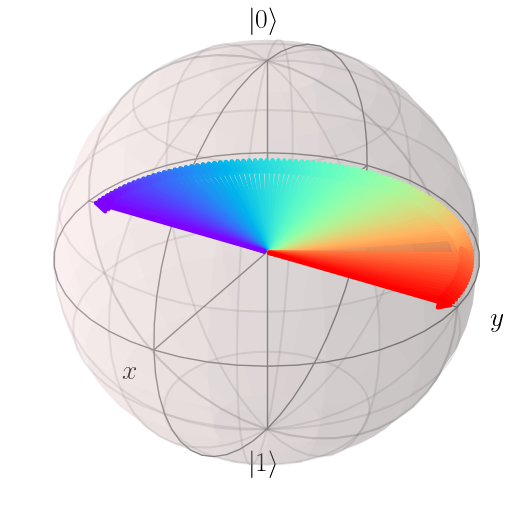

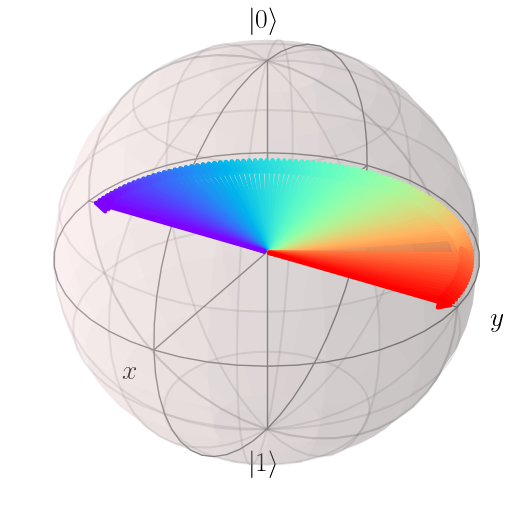

In [60]:
state = rho_0
expected_states = []
for i in range(num_muq):
    _U = U_rho(i*t/(num_muq-1),rho_plus)
    state = _U @ rho_0 @ dagger(_U)
    expected_states.append(Qobj(state))


b = Bloch()
b.fig
b.vector_color = color.tolist()
print('Expected:')
for state in expected_states:
    b.add_states(state)
b.show()

Kjaergaard visualization of the same protocol:

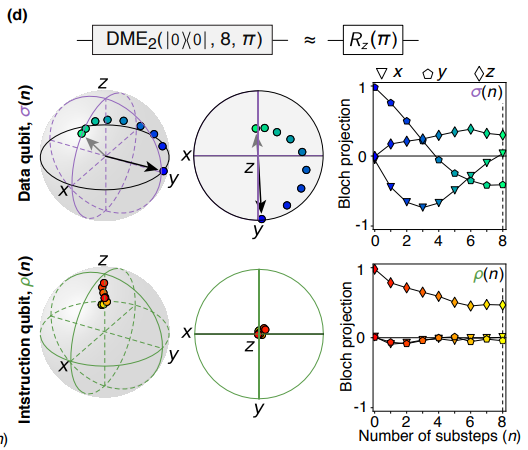

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "text.usetex": True, # Remove this line if your code doesn't run/ take too long
    "font.family": "serif",
    "figure.dpi": 100,
    "font.size": 14
})

In [62]:
norm = [np.linalg.norm(expected_states[-1].full() - qutip_state.full()) for qutip_state in qutip_states]
norm_dme = [np.linalg.norm(expected_states[-1].full() - qutip_state.full()) for qutip_state in qutip_dme_states]


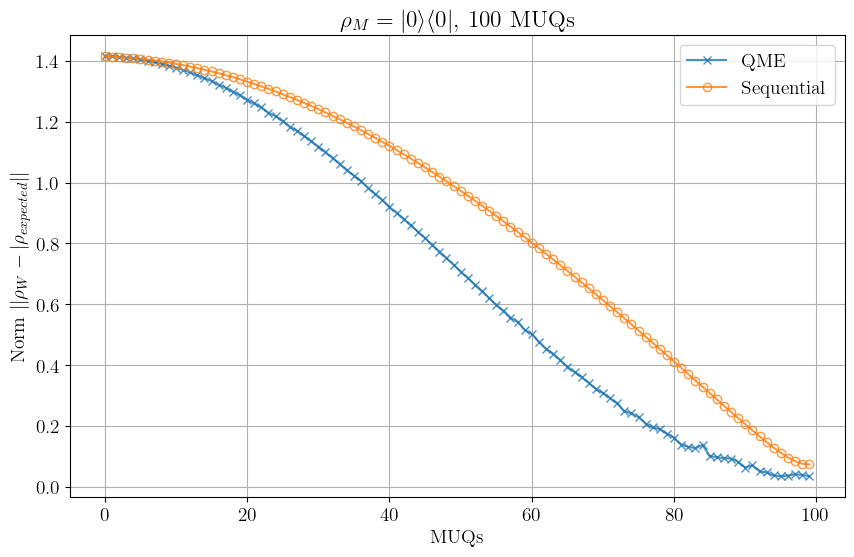

In [63]:
plt.plot(range(num_muq),norm,marker='x',alpha=0.8,label='QME')
plt.plot(range(num_muq),norm_dme,marker='o',markerfacecolor='none',alpha=0.8,label='Sequential')
plt.xlabel('MUQs')
plt.ylabel(r'Norm $|| \rho_W - |\rho_{expected} ||$')
plt.grid()
plt.title(r'$\rho_M = |0\rangle \langle 0|$, '+f'{num_muq} MUQs')
plt.legend()